# Buoys

In [1]:
import numpy as np, matplotlib.pyplot as plt

## Generate example
I'm expecting two data fields from the localisation backend:
- `(n_walls, n_buoys, n_dims)` shaped array of algae walls,
- `(n_walls, n_buoys, n_dims, n_dims)` shaped array of covariance matricies, giving the covariance of each buoy

These arrays should be well-ordered by Euclidian distance across `n_walls` and `n_buoys`,
so that the edge walls and edge buoys can be identified by `0` and `-1` indexing.

In [2]:
# generate algae walls
n_walls = 4
n_buoys = 4
walls = list()
for x in np.linspace(-10, 10, num=n_walls):
    wall = list()
    for y in np.linspace(-10, 10, num=n_buoys):
        wall.append([x, y, 0.0])
    walls.append(np.array(wall))
walls = np.array(walls)
print(walls)

[[[-10.         -10.           0.        ]
  [-10.          -3.33333333   0.        ]
  [-10.           3.33333333   0.        ]
  [-10.          10.           0.        ]]

 [[ -3.33333333 -10.           0.        ]
  [ -3.33333333  -3.33333333   0.        ]
  [ -3.33333333   3.33333333   0.        ]
  [ -3.33333333  10.           0.        ]]

 [[  3.33333333 -10.           0.        ]
  [  3.33333333  -3.33333333   0.        ]
  [  3.33333333   3.33333333   0.        ]
  [  3.33333333  10.           0.        ]]

 [[ 10.         -10.           0.        ]
  [ 10.          -3.33333333   0.        ]
  [ 10.           3.33333333   0.        ]
  [ 10.          10.           0.        ]]]


In [3]:
# rotate walls to ensure that stuff below generally works
# NOTE: this code is inefficient because this is just for generating an example
phi = np.deg2rad(90.0)
theta = np.deg2rad(24.0)
rot = np.array([
    [np.cos(theta), -np.sin(theta)],
    [np.sin(theta), np.cos(theta)]
])
newwalls = list()
for wall in walls:
    newwall = list()
    for buoy in wall:
        newbuoy = np.hstack((
            np.dot(rot, buoy[:2]),
            buoy[-1]
        ))
        newwall.append(newbuoy)
    newwalls.append(newwall)
walls = np.array(newwalls)
print(walls)

[[[ -5.06808815 -13.20282101   0.        ]
  [ -7.77966577  -7.11251796   0.        ]
  [-10.49124339  -1.02221491   0.        ]
  [-13.20282101   5.06808815   0.        ]]

 [[  1.02221491 -10.49124339   0.        ]
  [ -1.68936272  -4.40094034   0.        ]
  [ -4.40094034   1.68936272   0.        ]
  [ -7.11251796   7.77966577   0.        ]]

 [[  7.11251796  -7.77966577   0.        ]
  [  4.40094034  -1.68936272   0.        ]
  [  1.68936272   4.40094034   0.        ]
  [ -1.02221491  10.49124339   0.        ]]

 [[ 13.20282101  -5.06808815   0.        ]
  [ 10.49124339   1.02221491   0.        ]
  [  7.77966577   7.11251796   0.        ]
  [  5.06808815  13.20282101   0.        ]]]


In [4]:
np.save('walls.npy', walls)

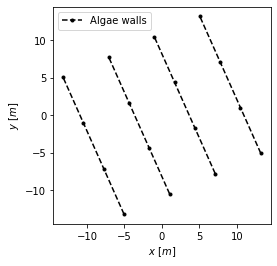

In [5]:
def plot(position, walls, plans=None):

    # figure and axis
    fig, ax = plt.subplots(1)

    # for each wall
    for i, wall in enumerate(walls):
        label = 'Algae walls' if i==0 else None
        ax.plot(wall[:,0], wall[:,1], 'k.--', label=label)

    # plans
    if plans is not None:
        ax.plot(plans[:,0], plans[:,1], 'k-x', label='Plan')

    # format
    ax.set_aspect('equal')
    ax.set_xlabel('$x~[m]$')
    ax.set_ylabel('$y~[m]$')
    ax.legend()
    plt.show()


plot(np.array([15, 15, 0]), walls)

## Plans
Based on Ivan's drawing, we want to execute a lawnmower that gets progressively closser to some side of the algae farm until the buoys are localised to some accuracy, hence to covariance matricies given above. Those covariance matricies will be used to decide when to stop the lawnmower. Once the first side of buoys are localised, then we move to the next wall, starting at the distance we succesully localised the first buoys with.

Let's make a plan object

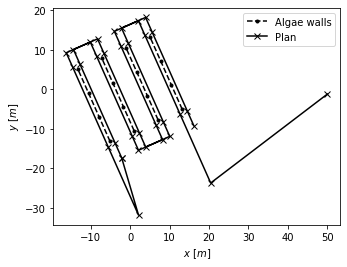

In [6]:
class A_Set_Linear_Plan:

    def __init__(self):
        pass

    @staticmethod
    def plan(
        x0, 
        x1, 
        n_rows, 
        row_sep, 
        x0_overshoot, 
        x1_overshoot,
        x0_lineup=None,
        x1_lineup=None,
        starboard=False,
        depth=0.0
    ):

        # sanity
        if x0_lineup is not None:
            assert(x0_overshoot < x0_lineup)
        if x1_lineup is not None:
            assert(x1_overshoot < x1_lineup)

        # parallel unit vector (x,y)
        par = x1[:2] - x0[:2]
        par /= np.linalg.norm(par)
        
        # perpendicular unit vector (x,y)
        perp = np.array([-par[1], par[0]]) if starboard else np.array([par[1], -par[0]])
            
        # construct a lawnmower
        wps = list()

        # i = iteration number, j = row number
        for i, j in enumerate(reversed(range(n_rows))):

            # i = 0, 2, 4, 6, 8, ...
            if not i%2:

                # intial lineup
                if x0_lineup is not None:
                    wps.append(x0[:2] + (row_sep*(j+1))*perp - x0_lineup*par)

                # adjacent to line endpoint
                wps.append(x0[:2] + (row_sep*(j+1))*perp - x0_overshoot*par)
                wps.append(x1[:2] + (row_sep*(j+1))*perp + x1_overshoot*par)

                # terminal lineup
                if x1_lineup is not None:
                    wps.append(x1[:2] + (row_sep*(j+1))*perp + x1_lineup*par)

            # i = 1, 3, 5, 7, 9, ...
            else:

                # initial lineup
                if x1_lineup is not None:
                    wps.append(x1[:2] + (row_sep*(j+1))*perp + x1_lineup*par)

                # adjacent to line endpoint
                wps.append(x1[:2] + (row_sep*(j+1))*perp + x1_overshoot*par)
                wps.append(x0[:2] + (row_sep*(j+1))*perp - x0_overshoot*par)

                # intial lineup
                if x0_lineup is not None:
                    wps.append(x0[:2] + (row_sep*(j+1))*perp - x0_lineup*par)

        # add depth and return waypoints
        wps = np.array(wps)
        wps = np.hstack((wps, np.full((wps.shape[0], 1), depth)))
        return wps

    @staticmethod
    def full_plan(
        pose, 
        walls,
        row_sep, 
        x0_overshoot, 
        x1_overshoot,
        x0_lineup=None,
        x1_lineup=None,
        first_lineup=None,
        starboard=False
    ):

        # distance between each buoy and AUV
        norms = np.linalg.norm(walls[[0,-1]] - pose, axis=2)

        # index of closest extremal wall
        i = norms.min(axis=1).argmin(axis=0)
        i = 0 if i == 0 else -1
        
        # now get closet extremal buoy 
        norms = np.linalg.norm(walls[i, [0,-1]] - pose, axis=1)
        j = norms.argmin(axis=0)
        j = 0 if j == 0 else -1

        # now let's order the walls based on (i,j)
        walls = np.flip(walls, axis=0) if i == -1 else walls
        walls = np.flip(walls, axis=1) if j == -1 else walls

        # waypoints
        waypoints = list()

        # construct waypoints
        for i, wall in enumerate(walls):

            # i = 0, 2, 4, ...
            if not i%2:
                wps = A_Set_Linear_Plan.plan(
                    x0=wall[0], 
                    x1=wall[-1], 
                    n_rows=1, 
                    row_sep=row_sep, 
                    x0_overshoot=x0_overshoot, 
                    x1_overshoot=x1_overshoot,
                    x0_lineup=first_lineup if i==0 else x0_lineup,
                    x1_lineup=x1_lineup,
                    starboard=starboard
                )
            
            # i = 1, 3, 5, ...
            else:
                wps = A_Set_Linear_Plan.plan(
                    x0=wall[-1], 
                    x1=wall[0], 
                    n_rows=1, 
                    row_sep=row_sep, 
                    x0_overshoot=x0_overshoot, 
                    x1_overshoot=x1_overshoot,
                    x0_lineup=x0_lineup,
                    x1_lineup=x1_lineup,
                    starboard=starboard
                )

            # add waypoint
            waypoints.append(wps)

        # construct path with AUV pose first
        waypoints = np.vstack(waypoints)
        waypoints = np.vstack((pose, waypoints))
        return waypoints

pose = np.random.uniform(low=0, high=2*np.pi)
r=50
pose = np.array([r*np.cos(pose), r*np.sin(pose), 0])
wps0 = A_Set_Linear_Plan.full_plan(pose, walls, 1, 1, 1, 5, 5, 20, starboard=True)
wps1 = A_Set_Linear_Plan.full_plan(wps0[-1], walls, 1, 1, 1, 5, 5, 20, starboard=True)
wps = np.vstack((wps0, wps1))
plot(pose, walls, wps)